# Navigation

---

In this notebook, you can train an agent to navigate the Unity ML-Agents Bananna environment

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md)

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import gym
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from dqn_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# set the enviroment
env = UnityEnvironment(file_name="Banana_Windows_x86_64\Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Train the Agent

Finally we will train an agent to navigate this enviroment in order to maximise score.
For a description of the all of the hyperparameters please read below.
Note also that the 3 extra modifications have recently been added and it is not currently possible to turn them off - this will come in a future update.

#### Output
This function will output the scores obtained during training, which will be presented in a plot below. Also it will save the weights to the file checkpoint.pth, to be used for testing later. Weight saving will happen after training has completed but can also be saved early using the average score threshold (currently set to 20.0).


Episode 100	Average Score: 0.53
Episode 200	Average Score: 4.77
Episode 300	Average Score: 8.00
Episode 400	Average Score: 11.03
Episode 500	Average Score: 12.92
Episode 600	Average Score: 14.54
Episode 700	Average Score: 15.26
Episode 800	Average Score: 16.16
Episode 900	Average Score: 17.11
Episode 1000	Average Score: 17.26


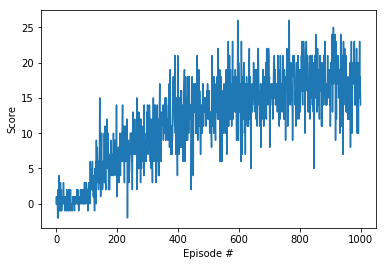

In [3]:
agent = None
state_size, action_size = len(env_info.vector_observations[0]), brain.vector_action_space_size

def dqn(n_episodes=1000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, \
    Double_DQN = True, Priority_Replay = True, Duel_DQN = True, Priority_Replay_Paras = [0.5, 0.5, 0.5]):
    global agent
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        Double_DQN (bool): whether to implement Double_DQN modification
        Priority_Replay (bool): whether to implement Priority_Replay modification
        Duel_DQN (bool): whether to implement Duel_DQN modification
        Priority_Replay_Paras (list of e,a,b floats):
        e adds to all priorities, which are raised to power of a, while b is used to de-bias the q-updates
    """
    agent = Agent(state_size, action_size, seed=0, Double_DQN=Double_DQN, Priority_Replay_Paras=Priority_Replay_Paras)

    scores = []                        # list containing scores from each episode
    saved = False
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):

        # reset enviroment
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        
        # update beta towards 1
        agent.update_beta((i_episode-1)/(n_episodes-1))

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            #next_state, reward, done = env.step(action)
            #print(action)
            env_info = env.step(int(action))[brain_name]
            next_state, reward, done = env_info.vector_observations[0]  , env_info.rewards[0], env_info.local_done[0]

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window)>=20.0:
            if not saved:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                saved = True
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')            
    if not saved:
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()